In [161]:
import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
import datetime
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)

# load tensorboard extension
%reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
%tensorboard --logdir logs

#### Loading the relevant datasets (15/100)

(15026, 4)
(4696, 4)
(3757, 4)
['age' 'ethnicity' 'gender' 'img_name']
5
Train Gender Distribution:
0    0.52336
1    0.47664
Name: gender, dtype: float64

Test Gender Distribution:
0    0.522998
1    0.477002
Name: gender, dtype: float64

Val Gender Distribution:
0    0.523024
1    0.476976
Name: gender, dtype: float64

Train Ethnicity Distribution:
0    0.424065
1    0.190936
3    0.167976
2    0.145481
4    0.071543
Name: ethnicity, dtype: float64

Test Eethnicity Distribution:
0    0.423978
1    0.190801
3    0.168228
2    0.145443
4    0.071550
Name: ethnicity, dtype: float64

Val Eethnicity Distribution:
0    0.424009
1    0.190844
3    0.168219
2    0.145595
4    0.071334
Name: ethnicity, dtype: float64



<AxesSubplot:>

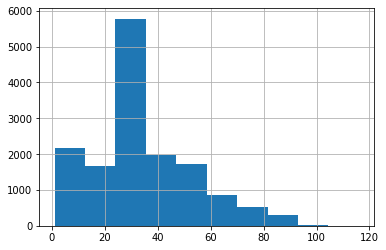

In [116]:
# load the datasets using the csv files train, val and test (3)
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
val = pd.read_csv('./data/val.csv')

# print the shapes of the dataframes (3)
print(train.shape)
print(test.shape)
print(val.shape)

# print the column names from either one of the dataframes (1)
print(train.columns.values)

num_ethnecities = train['ethnicity'].nunique()
print(num_ethnecities)

# print the proportional distribution of gender in all three datasets(i.e., number of male and female) (3)
print(f"Train Gender Distribution:\n{train['gender'].value_counts() / len(train)}\n")
print(f"Test Gender Distribution:\n{test['gender'].value_counts() / len(test)}\n")
print(f"Val Gender Distribution:\n{val['gender'].value_counts() / len(val)}\n")

# print the proportional distribution of ethnicity in all three datasets (3)
print(f"Train Ethnicity Distribution:\n{train['ethnicity'].value_counts() / len(train)}\n")
print(f"Test Eethnicity Distribution:\n{test['ethnicity'].value_counts() / len(test)}\n")
print(f"Val Eethnicity Distribution:\n{val['ethnicity'].value_counts() / len(val)}\n")

# plot the age distribution from the training dataset where the x-axis plots the age and the y-axis 
# depicts the count of individuals within each age group. For example, individuals with age=1 are: (2)
train['age'].hist()


#### Create the ImageDataGenerators (22/100)

In [117]:
def make_directories():
    d = datetime.datetime.today()
    timestamp = d.strftime('%Y%m%d_%H%M%S')
    # folder to store the tensorboard logs
    tensorlog_folder = os.path.join(os.path.curdir, 'logs', timestamp)
    # folder to store the trained models
    checkpoint_folder = os.path.join(os.path.curdir, 'models', timestamp)

    os.mkdir(tensorlog_folder)
    os.mkdir(checkpoint_folder)

    return checkpoint_folder, tensorlog_folder

Found 15026 validated image filenames.
Found 3757 validated image filenames.
Found 4696 validated image filenames.
19
2
1


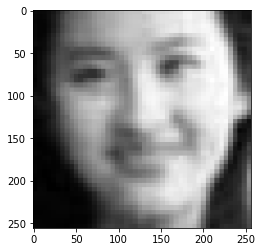

In [152]:
# ImageDataGenerator is an iterator.

# specify the batch size hyperparameter. You can experiment with different batch sizes
batch_size = 9

# create the ImageDataGenerator with rescaling that will generate batched tensors representing images with real-time data augmentation
# use at least two of the augmentation strategies. For example, fill_mode='nearest'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (3)
train_img_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=None,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.0,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    dtype=None,
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance to link the image folder and the dataframe.
# also include the, batch size, image size and the seed.
# make sure to include the following arguments
# color_mode='grayscale', class_mode='multi_output'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (5)
train_generator = train_img_gen.flow_from_dataframe(
  dataframe=train,
  directory='./data/images/train/',
  x_col='img_name',
  y_col=['age','ethnicity','gender'],
  class_mode='multi_output',
  color_mode='grayscale',
  batch_size=batch_size,
  shuffle=True,
  seed = SEED
)

# similarly, create an ImageDataGenerator for the validation dataset and make sure not to use any of the augmentation strategies except rescaling the image
# (2)
val_img_gen = ImageDataGenerator(
      rescale=1./255
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance with the same arguments as above
# make sure to specify the following arguments:
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)
val_generator = val_img_gen.flow_from_dataframe(
  dataframe=val,
  directory='./data/images/val/',
  x_col='img_name',
  y_col=['age','ethnicity','gender'],
  class_mode='multi_output',
  color_mode='grayscale',
  batch_size=batch_size,
  shuffle=True,
  seed = SEED
)


# use the method "flow_from_dataframe" from the val_img_gen instance to link the test dataframe and the test data folder
# In addition, make sure to specify the following arguments
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)
test_img_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_img_gen.flow_from_dataframe(
  dataframe=test,
  directory='./data/images/test/',
  x_col='img_name',
  y_col=['age','ethnicity','gender'],
  class_mode='multi_output',
  color_mode='grayscale',
  batch_size=batch_size,
  shuffle=True,
  seed = SEED
)


# enumerate through the validation data generator created above and plot first grayscale image 
# (2)
tmpx = enumerate(val_generator)
for i, element in tmpx:
    if i == 8:
      print(element[1][0][i])
      print(element[1][1][i])
      print(element[1][2][i])
      plt.imshow(element[0][i], cmap = 'gray')
      break

In [119]:
print(val_generator.image_shape)


(256, 256, 1)


#### Create the model (44/100)

In [156]:
# specify the model input with the required shape 
# (1)
# TODO
in_shape = keras.Input(shape=(256, 256, 1))

# The shared layers
# Include at least one Conv2D layer, MaxPooling2D layer and a Flatten layer
# you can have as many layers as possible, but make sure not to overfit your model using the training data
# TODO
# (10)

layer1 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', name="layer1")
layer2 = tf.keras.layers.MaxPool2D(2,2, name="layer2")
layer3 = tf.keras.layers.Flatten(name="layer3")

sharedLayers = layer3(layer2(layer1(in_shape))) # layer3(layer2(layer1(flattenLayer(in_shape))))

# Task specific layers
# Include at least one Dense layer as a task specific layer before generating the output for age
# TODO
# (2)
#  ageTaskSpecificLayer = tf.keras.layers.Dense(64, activation='relu', name='age_task')


# Include the age output and make sure to include the following arguments
# activation='linear', name='xxx'(any name)
# make sure to name your output layers so that different metrics to be used can be linked accordingly
# please note that the age prediction is a regression task
# TODO
# (2)
ageLayer = tf.keras.layers.Dense(1, activation='linear', name='age')

ageOutput = ageLayer(sharedLayers)

# Similar to above, specify one or more Dense layers as task specific layers for ethnicity prediction
# TODO
# (2)
# ethnicityTaskSpecificLayer = tf.keras.layers.Dense(64, activation='relu', name='ethnicity_task')

# Include the ethnicity output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a multi-class classification task
# TODO
# (2)

ethnicityLayer = tf.keras.layers.Dense(5, activation='sigmoid', name='ethnicity')

ethnicityOutput = ethnicityLayer(sharedLayers)

# Similar to above, specify one or more Dense layers as task specific layers for gender prediction
# TODO
# (2)

# genderTaskSpecificLayer = tf.keras.layers.Dense(64, activation='relu', name='gender_task')


# Include the gender output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a binary classification task
# TODO
# (2)

genderLayer = tf.keras.layers.Dense(1, activation='sigmoid', name='gender')

genderOutput = genderLayer(sharedLayers)

# create the model with the required input and the outputs.
# pelase make sure that the outputs can be included in a list and make sure to keep note of the order
# TODO
# (3)

outputs = [ageOutput, genderOutput, ethnicityOutput]
# outputs = sharedLayers

model = tf.keras.Model(inputs=in_shape,outputs=outputs, name="tmo")

# print the model summary
# TODO
# (0.5)
print(model.summary())


Model: "tmo"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 layer1 (Conv2D)                (None, 254, 254, 32  320         ['input_47[0][0]']               
                                )                                                                 
                                                                                                  
 layer2 (MaxPooling2D)          (None, 127, 127, 32  0           ['layer1[0][0]']                 
                                )                                                               

In [160]:
# Instantiate the optimizer with the learning rate. You can start with the learning rate 1e-3(0.001).
# Both the optimizer and the learning rate are hyperparameters that you can finetune
# For example, you can start with the "RMSprop" optimizer
# TODO
# (2)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

# specify the losses to be used for each task: age, ethnicity and gender prediction 
# (0.5)
losses = [
#age
tf.keras.losses.poisson,
#gender
tf.keras.losses.BinaryCrossentropy,
#ethnicity
tf.keras.losses.CategoricalHinge
]

# compile the model with the optimizer, loss, loss_weights and the metrics for each task
# apply the following weights to the losses to balance the contribution of each loss to the total loss
# loss_weights=[0.001, 0.5, 0.5]
# please remember to use the relevant metric for each task by assigning it to the correct output
# TODO
# (2)

# compile the model
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer='rmsprop', loss=tf.nn.softmax_cross_entropy_with_logits, metrics=['accuracy'])

check_dir, tboard_dir = make_directories()

# Define the callbacks
# EarlyStopping: monitor the validation loss while waiting for 3 epochs before stopping
# can restore the best weights
# TODO
# (2)
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ModelCheckpoint
# monitor validation loss and save the best model weights
# TODO
# (2)
checkpoints = keras.callbacks.ModelCheckpoint(
    filepath=check_dir,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

# Initiallize TensorBoard
# TODO
# (2)
tensorboard = keras.callbacks.TensorBoard(
    log_dir=tboard_dir
)

# ReduceLROnPlateau
# reduce the learning rate by a factor of 0.1 after waiting for 2 epochs while monitoring validation loss
# specify a minimum learning rate to be used
# TODO
# (2)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

callbacks = [early_stop, checkpoints, tensorboard, reduce_lr]

# fit the model with training and validation generators
# In addition please specify the following arguments
# steps_per_epoch=len(df_train)/batch_size
# validation_steps=len(df_val)/batch_size
# (5)

model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        batch_size=64, 
        callbacks=[reduce_lr, early_stop, checkpoints, tensorboard]
)

Epoch 1/10
1670/1670 [==============================] - ETA: 0s - loss: 3.8356 - age_loss: 0.0000e+00 - gender_loss: 0.0000e+00 - ethnicity_loss: 3.8356 - age_accuracy: 0.0470 - gender_accuracy: 0.1909 - ethnicity_accuracy: 0.5234

2022-04-04 23:53:55.591011: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/20220404_234850/assets
1670/1670 [==============================] - 305s 182ms/step - loss: 3.8356 - age_loss: 0.0000e+00 - gender_loss: 0.0000e+00 - ethnicity_loss: 3.8356 - age_accuracy: 0.0470 - gender_accuracy: 0.1909 - ethnicity_accuracy: 0.5234 - val_loss: 3.8383 - val_age_loss: 0.0000e+00 - val_gender_loss: 0.0000e+00 - val_ethnicity_loss: 3.8383 - val_age_accuracy: 0.0490 - val_gender_accuracy: 0.1908 - val_ethnicity_accuracy: 0.5230 - lr: 0.0010
Epoch 2/10
1670/1670 [==============================] - 333s 199ms/step - loss: 3.8356 - age_loss: 0.0000e+00 - gender_loss: 0.0000e+00 - ethnicity_loss: 3.8356 - age_accuracy: 0.0470 - gender_accuracy: 0.1909 - ethnicity_accuracy: 0.5234 - val_loss: 3.8383 - val_age_loss: 0.0000e+00 - val_gender_loss: 0.0000e+00 - val_ethnicity_loss: 3.8383 - val_age_accuracy: 0.0490 - val_gender_accuracy: 0.1908 - val_ethnicity_accuracy: 0.5230 - lr: 0.0010
Epoch 3/10
1670/1670 [============================

#### Making predictions on test data (14/100)

In [ ]:
# evaluate the trained model using the test generator
# print only the test accuracy for ethnicity and gender predictions (4)
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

587/587 [==============================] - 56s 96ms/step - loss: 3.9568e-09 - flatten_loss: 3.9568e-06 - gender_loss: 0.0000e+00 - ethnicity_loss: 0.0000e+00


{'loss': 3.956779348612827e-09,
 'flatten_loss': 3.956778982683318e-06,
 'gender_loss': 0.0,
 'ethnicity_loss': 0.0}

In [ ]:

# generate predictions using the test generator
(2)
pred = model.predict(test_generator)
print(pred)

# extract the ethnicity predictions
(2)
# print the classification report for predicting ethnicity
(2)

# extract the gender predictions where probabilities above 0.5 are considered class 1 and if not, class 0
(2)
# print the classification report for predicting gender
(2)

[array([[-24.551634],
       [-30.454792],
       [-29.439297],
       ...,
       [-15.10799 ],
       [-29.511108],
       [-27.71646 ]], dtype=float32), array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32), array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)]


2

#### Present prediction results on test data(5/100)

Present your findings for 5 different runs by fine-tuning the hyperparameters. The results table must contain the following fields
- A minimum of 5 hyperparameters that you have fine-tuned
- Mean absolute error for age
- Accuracy for ethnicity prediction
- Accuracy for gender prediction
Please use a table format similar to the one mentioned below when presenting the results.

| Hyperparameters | Age(MAE) | Ethnicity(Accuracy)| Gender(Accuracy) |
|-----------------|----------|--------------------|------------------|
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
